# Title: Scraping and morphem analysis
---
### 주제: 검색어를 기준으로 중앙일보의 기사들을 스크래핑하고, 기사 내용의 명사들을 도출하여 워드 클라우드하기
### 동기: 스크래핑 연습과 워드클라우드 라이브러리 사용
- 사용한 라이브러리
  - sys
  - os
  - collections.Counter
  - requests
  - lxml
  - time.sleep
  - bs4.BeautifulSoup
  - knolpy.tag.Okt
  - wordcloud.WordCloud
  - matplotlib.pyplot
---

# 중앙일보 웹 페이지 분석
---

**1. 중앙일보 뉴스 접속 모습**
<br>
<img src="./img/joonang_approach_1.png" align="left" width="500" height="100">
<br>
<br>
<br>
<br>
<br>
<br>

**2. 스더보기 클릭 > 전체 뉴스 더보기 클릭 모습**
<br>
<img src="./img/joonang_approach_3.png" align="left" width="500" height="100">
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

**3. 개발자도구를 이용한 html 분석**
<br>
<img src="./img/joonang_approach_4.png" align="left" width="500" height="300">
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

**4. 접근 url 뜯어보기**
<br>
https://search.joins.com/TotalNews?Keyword=%EA%B2%BD%EC%A0%9C&SearchCategoryType=TotalNews&Page=1&PageSize=10&SortType=New&PeriodType=All&ScopeType=All&ImageType=All&JplusType=All&BlogType=All&ImageSearchType=Image&TotalCount=0&StartCount=0&IsChosung=False&IssueCategoryType=All&IsDuplicate=True&IsNeedTotalCount=True
→ 주요 키워드는 'search.joins.com/TotalNews?' / 'Keyword=' / 'SearchCategoryType=TotalNews' / 'Page=' 라는걸 알 수 있습니다.
<br>
<br>

**5. 링크별 기사 html 뜯어보기**
<br>
<img src="./img/joonang_approach_5.png" align="left" width="500" height="300">
<br>

In [1]:
import sys
import os
from collections import Counter # 문자열을 기준으로 각각의 요소별 개수 찾는 라이브러리
import requests
import lxml
from time import sleep
from bs4 import BeautifulSoup
from konlpy.tag import Okt # 문장을 기준으로 명사 도출 라이브러리
from wordcloud import WordCloud # 워드클라우드 제공 라이브러리
import matplotlib.pyplot as plt # 워드클라우드를 표현하기위한 파레트

In [2]:
target_url_domain = "https://search.joins.com/TotalNews?page="
target_url_query = "&Keyword="
target_url_rest = "&SearchCategoryType=TotalNews"

In [3]:
def get_link_from_news_article(keword:str, total_page_num:int) -> list:
    """키워드에 해당하는 기사 링크 정보를 반환

    return 기사 링크 리스트.
    """
    article_link_list = []

    for curr_page_num in range(1, total_page_num + 1):
        response = requests.get(target_url_domain + str(curr_page_num) + target_url_query + keword + target_url_rest)
        html = response.text
        soup = BeautifulSoup(html, 'lxml')

        news_articles_body = soup.find('ul', attrs={'class':'list_default'}) # 키워드에 해당하는 기사 목록 접근
        news_articles = news_articles_body.find_all('li')

        for article in news_articles:
            article_link_list.append(article.a['href'])

    return article_link_list

In [4]:
# 키워드 결과들의 링크 반환
article_link_list = get_link_from_news_article('경제', 2)
article_link_list

['https://news.joins.com/article/23230951',
 'https://news.joins.com/article/23230950',
 'https://news.joins.com/article/23230953',
 'https://news.joins.com/article/23230952',
 'https://news.joins.com/article/23230947',
 'https://news.joins.com/article/23230946',
 'https://news.joins.com/article/23230948',
 'https://news.joins.com/article/23230949',
 'https://news.joins.com/article/23230907',
 'https://news.joins.com/article/23230884',
 'https://news.joins.com/article/23230883',
 'https://news.joins.com/article/23230878',
 'https://news.joins.com/article/23230864',
 'https://news.joins.com/article/23230839',
 'https://news.joins.com/article/23230833',
 'https://news.joins.com/article/23230832',
 'https://news.joins.com/article/23230823',
 'https://news.joins.com/article/23230819',
 'https://news.joins.com/article/23230818',
 'https://news.joins.com/article/23230817']

In [8]:
def write_article_body_in_file(article_link_list:list, file_name:str, sleep_seconds:float):
    """기사 링크에 해당하는 본문 내용을 파일에 쓰기."""
    try:
        with open(file_name, 'wt', encoding='utf-8') as f:
            for url in article_link_list:
                f.write(get_article_body_for_url(url) + '\n')
                sleep(sleep_seconds)
    except FileNotFoundError as ex:
        print(ex)

In [9]:
def get_article_body_for_url(url:str) -> str:
    """URL 링크의 본문 내용 가져오기

    return 기사 본문 내용.
    """
    response = requests.get(url)
    html = response.text
    soup = BeautifulSoup(html, 'lxml')
    
    article_body = soup.find('div', attrs={'id':'article_body'})
    return article_body.text.strip()

In [10]:
# 링크를 이용하여, 각 링크들의 기사 본문 내용을 SCRAPING 하여 파일에 쓰기
write_article_body_in_file(article_link_list, 'D:\\web-scraping\\project\\article_20181220.txt', 0.5)

In [13]:
def draw_word_cloud(read_file_name:str, most_common_keword_num:int):
    """워드클라우드 그리기

    read_file_name: 워드클라우드의 대상 데이터 파일
    most_common_keword_num: 워드클라우드로 보여주기 위한 주요 키워드 갯수.
    """
    try:
        stop_words = ['전', '등', '도', '신', '이', '그', '바', '기자', '선', '건', '때', '흐', '것', '로', '프', '더', '고', '위']
        okt = Okt()

        with open(read_file_name, 'r', encoding='utf-8') as f:
            contents = f.readlines()
            
            all_sentence = ' '.join(contents)
            nouns = [noun for noun in okt.nouns(all_sentence) if noun not in stop_words]
            data = Counter(nouns).most_common(most_common_keword_num)
            # print(nouns)
            # print(data)

            word_cloud = WordCloud(
                font_path='/Fonts/malgun.ttf',
                relative_scaling=0.2,
                background_color='white',
                max_words=2000,
                width=1000,
                height=1000,
            ).generate_from_frequencies(
                dict(data),
                # max_font_size=35,
                )

            plt.figure(figsize=(16, 8))
            plt.imshow(word_cloud, interpolation='bilinear')
            plt.axis('off')
            plt.show()

    except FileNotFoundError as ex:
        print(ex)

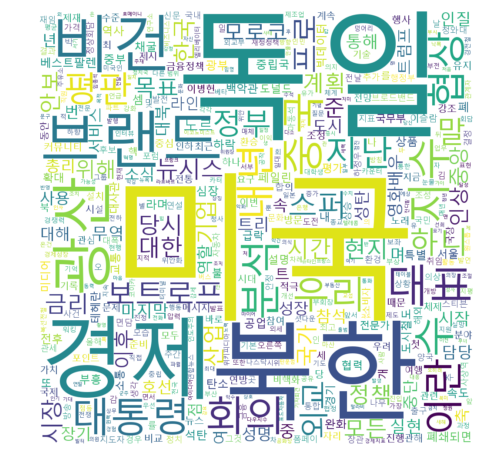

In [12]:
draw_word_cloud('D:\\web-scraping\\project\\article_20181220.txt', 500)

In [14]:
def main(argv):
    """중앙일보에서 특정 키워드를 포함하는 신문기사 크롤링 메인 모듈."""
    # argv = ['데이터', '1', 'D:\\article_file2.txt', '0.0', '50']
    if len(argv) < 5:
        print('[키워드][총 페이지 개수][기사 추출 결과 저장용 파일명 - 경로 포함][sleep seconds][most common keyword number]')
        print(argv)
        return

    try:
        keword = argv[0]
        total_page_num = int(argv[1])
        article_file_name = argv[2]
        sleep_seconds = float(argv[3])
        most_common_keword_num = int(argv[4])

        article_link_list = get_link_from_news_article(keword, total_page_num)
        write_article_body_in_file(article_link_list, article_file_name, sleep_seconds)
        draw_word_cloud(article_file_name, most_common_keword_num)
    except EOFError as ex:
        print(ex)
    except KeyboardInterrupt as ex: # ctrl + c
        print(ex)

In [ ]:
if __name__ == '__main__':
    # python main.py 감옥 2 D:\article_file5.txt 0 500
    # python main.py 박근혜 2 D:\article_file6.txt 0 500

    # print(sys.argv)
    main(sys.argv)

# 느낀 점
- Scraping 연습과 wordcloud 라이브러리 등을 익힐 수 있는 기회여서 좋았습니다.

# 어려웠던 점
- 라이브러리들을 사용함에 있어 영어로된 내용들을 이해하여 적용해야 하는 부분이 곤란했던 것 같습니다. 실제론 이해가 안되면 해당 기능들을 돌려보며 이해한 부분도 있습니다.

# 보완할 부분
- 자동화 부분에 대한 처리가 들어가면 좋을듯 하며, 뒤에 있을 미니 프로젝트에선 DB 와도 연동하여 데이터를 파일이 아닌 DB 에 담아 분석해볼 수 있도록 개선하면 좋을듯합니다.

# 소감
- 수업시간에 진행했던 내용들을 가지고 만들어본 프로그램이며, 그 외에 기타 라이브러리들을 이용하여 구현해보며 기능들을 익힐 수 있어 좋았습니다. 감사합니다.^^